In [1]:
from IPython import get_ipython
ip = get_ipython()
if ip is not None:
    ip.run_line_magic('load_ext', 'pymor.discretizers.builtin.gui.jupyter')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='torch')
import pymor.tools.random
pymor.tools.random._default_random_state = None

The pymor.discretizers.builtin.gui.jupyter extension is already loaded. To reload it, use:
  %reload_ext pymor.discretizers.builtin.gui.jupyter


In [2]:
from pymor.basic import *
import numpy as np

domain = RectDomain(([-1,-1], [1,1]))
indicator_domain = ExpressionFunction(
    '(-2/3. <= x[..., 0]) * (x[..., 0] <= -1/3.) * (-2/3. <= x[..., 1]) * (x[..., 1] <= -1/3.) * 1. \
   + (-2/3. <= x[..., 0]) * (x[..., 0] <= -1/3.) *  (1/3. <= x[..., 1]) * (x[..., 1] <=  2/3.) * 1.',
    dim_domain=2, shape_range=())
rest_of_domain = ConstantFunction(1, 2) - indicator_domain

f = ExpressionFunction('0.5*pi*pi*cos(0.5*pi*x[..., 0])*cos(0.5*pi*x[..., 1])', dim_domain=2, shape_range=())

parameters = {'diffusion': 2}
thetas = [ExpressionParameterFunctional('1.1 + sin(diffusion[0])*diffusion[1]', parameters,
                                       derivative_expressions={'diffusion': ['cos(diffusion[0])*diffusion[1]',
                                                                             'sin(diffusion[0])']}),
          ExpressionParameterFunctional('1.1 + sin(diffusion[1])', parameters,
                                       derivative_expressions={'diffusion': ['0',
                                                                             'cos(diffusion[1])']}),

                                       ]
diffusion = LincombFunction([rest_of_domain, indicator_domain], thetas)

theta_J = ExpressionParameterFunctional('1 + 1/5 * diffusion[0] + 1/5 * diffusion[1]', parameters,
                                           derivative_expressions={'diffusion': ['1/5','1/5']})

problem = StationaryProblem(domain, f, diffusion, outputs=[('l2', f * theta_J)])

In [3]:
mu_bar = problem.parameters.parse([np.pi/2,np.pi/2])

fom, data = discretize_stationary_cg(problem, diameter=1/50, mu_energy_product=mu_bar)
parameter_space = fom.parameters.space(0, np.pi)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

In [4]:
output_functional = fom.rhs.H * theta_J
fom = fom.with_(output_functional=output_functional)

In [5]:
def fom_objective_functional(mu):
    return fom.output(mu)[0]

In [6]:
initial_guess = fom.parameters.parse([0.25, 0.5])

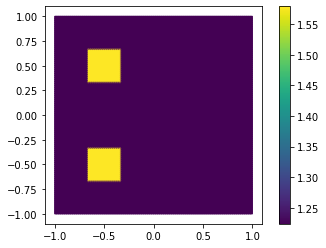

Output()

In [7]:
from pymor.discretizers.builtin.cg import InterpolationOperator

diff = InterpolationOperator(data['grid'], problem.diffusion).as_vector(initial_guess)
fom.visualize(diff)

In [8]:
print(data['grid'])

Tria-Grid on domain [-1,1] x [-1,1]
x0-intervals: 100, x1-intervals: 100
elements: 40000, edges: 60200, vertices: 20201


In [9]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12.0, 8.0)
mpl.rcParams['font.size'] = 12
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.subplot.bottom'] = .1

from mpl_toolkits.mplot3d import Axes3D # required for 3d plots
from matplotlib import cm # required for colors

import matplotlib.pyplot as plt
from time import perf_counter

def compute_value_matrix(f, x, y):
    f_of_x = np.zeros((len(x), len(y)))
    for ii in range(len(x)):
        for jj in range(len(y)):
            f_of_x[ii][jj] = f((x[ii], y[jj]))
    x, y = np.meshgrid(x, y)
    return x, y, f_of_x

def plot_3d_surface(f, x, y, alpha=1):
    X, Y = x, y
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    x, y, f_of_x = compute_value_matrix(f, x, y)
    ax.plot_surface(x, y, f_of_x, cmap='Blues',
                    linewidth=0, antialiased=False, alpha=alpha)
    ax.view_init(elev=27.7597402597, azim=-39.6370967742)
    ax.set_xlim3d([-0.10457963, 3.2961723])
    ax.set_ylim3d([-0.10457963, 3.29617229])
    return ax

def addplot_xy_point_as_bar(ax, x, y, color='orange', z_range=None):
    ax.plot([y, y], [x, x], z_range if z_range else ax.get_zlim(), color)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

<Axes3DSubplot:>

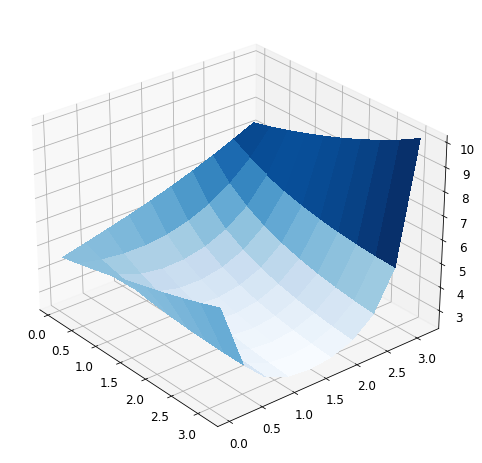

In [10]:
ranges = parameter_space.ranges['diffusion']
XX = np.linspace(ranges[0] + 0.05, ranges[1], 10)
YY = XX

plot_3d_surface(fom_objective_functional, XX, YY)

In [11]:
reference_minimization_data = {'num_evals': 0,
                               'evaluations' : [],
                               'evaluation_points': [],
                               'time': np.inf}

def record_results(function, data, mu):
    QoI = function(mu)
    data['num_evals'] += 1
    # we need to make sure to copy the data, since the added mu will be changed inplace by minimize afterwards
    data['evaluation_points'].append([fom.parameters.parse(mu)['diffusion'][:][0],
                                      fom.parameters.parse(mu)['diffusion'][:][1]])
    data['evaluations'].append(QoI[0])
    return QoI

def report(result, data, reference_mu=None):
    if (result.status != 0):
        print('\n failed!')
    else:
        print('\n succeded!')
        print('  mu_min:    {}'.format(fom.parameters.parse(result.x)))
        print('  J(mu_min): {}'.format(result.fun[0]))
        if reference_mu is not None:
            print('  absolute error w.r.t. reference solution: {:.2e}'.format(np.linalg.norm(result.x-reference_mu)))
        print('  num iterations:     {}'.format(result.nit))
        print('  num function calls: {}'.format(data['num_evals']))
        print('  time: {:.5f} seconds'.format(data['time']))
        if 'offline_time' in data:
            print('  offline time: {:.5f} seconds'.format(data['offline_time']))
        if 'enrichments' in data:
            print('  model enrichments: {}'.format(data['enrichments']))
    print('')

In [12]:
from functools import partial
from scipy.optimize import minimize

tic = perf_counter()
fom_result = minimize(partial(record_results, fom_objective_functional, reference_minimization_data),
                      initial_guess.to_numpy(),
                      method='L-BFGS-B', jac=False,
                      bounds=(ranges, ranges),
                      options={'ftol': 1e-15})
reference_minimization_data['time'] = perf_counter()-tic
reference_mu = fom_result.x

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

In [13]:
report(fom_result, reference_minimization_data)


 succeded!
  mu_min:    {diffusion: [1.4246544581196507, 3.141592653589793]}
  J(mu_min): 2.3917078762356825
  num iterations:     9
  num function calls: 36
  time: 3.16555 seconds



Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

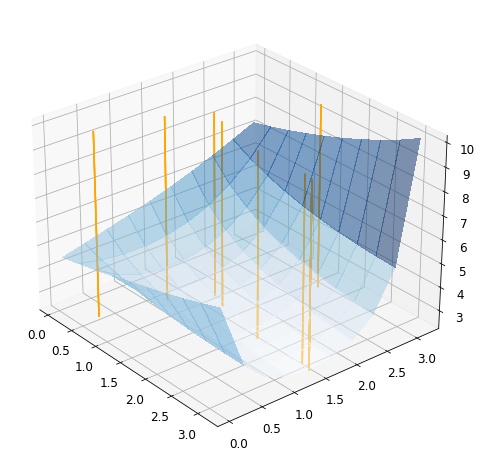

In [14]:
reference_plot = plot_3d_surface(fom_objective_functional, XX, YY, alpha=0.5)

for mu in reference_minimization_data['evaluation_points']:
    addplot_xy_point_as_bar(reference_plot, mu[0], mu[1])

In [15]:
from pymor.algorithms.greedy import rb_greedy
from pymor.reductors.coercive import CoerciveRBReductor

from pymor.parameters.functionals import MinThetaParameterFunctional

coercivity_estimator = MinThetaParameterFunctional(fom.operator.coefficients, mu_bar)

training_set = parameter_space.sample_uniformly(25)
training_set_simple = [mu['diffusion'] for mu in training_set]

RB_reductor = CoerciveRBReductor(fom, product=fom.energy_product, coercivity_estimator=coercivity_estimator)

In [16]:
RB_greedy_data = rb_greedy(fom, RB_reductor, training_set, atol=1e-2)

num_RB_greedy_extensions = RB_greedy_data['extensions']
RB_greedy_mus, RB_greedy_errors = RB_greedy_data['max_err_mus'], RB_greedy_data['max_errs']

rom = RB_greedy_data['rom']

print('RB system is of size {}x{}'.format(num_RB_greedy_extensions, num_RB_greedy_extensions))
print('maximum estimated model reduction error over training set: {}'.format(RB_greedy_errors[-1]))

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

RB system is of size 3x3
maximum estimated model reduction error over training set: 0.00935354954250121


Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

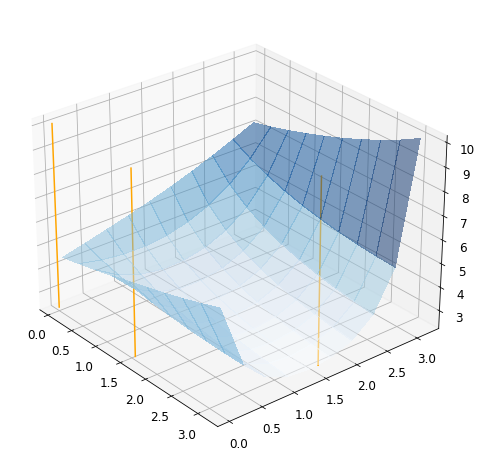

In [17]:
ax = plot_3d_surface(fom_objective_functional, XX, YY, alpha=0.5)

for mu in RB_greedy_mus[:-1]:
    mu = mu.to_numpy()
    addplot_xy_point_as_bar(ax, mu[0], mu[1])

In [18]:
def rom_objective_functional(mu):
    return rom.output(mu)[0]

RB_minimization_data = {'num_evals': 0,
                        'evaluations' : [],
                        'evaluation_points': [],
                        'time': np.inf,
                        'offline_time': RB_greedy_data['time']
                        }

tic = perf_counter()
rom_result = minimize(partial(record_results, rom_objective_functional, RB_minimization_data),
                      initial_guess.to_numpy(),
                      method='L-BFGS-B', jac=False,
                      bounds=(ranges, ranges),
                      options={'ftol': 1e-15})
RB_minimization_data['time'] = perf_counter()-tic

In [19]:
report(rom_result, RB_minimization_data, reference_mu)


 succeded!
  mu_min:    {diffusion: [1.424664977625628, 3.141592653589793]}
  J(mu_min): 2.3917078349971876
  absolute error w.r.t. reference solution: 1.05e-05
  num iterations:     8
  num function calls: 30
  time: 0.01425 seconds
  offline time: 1.56933 seconds



Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

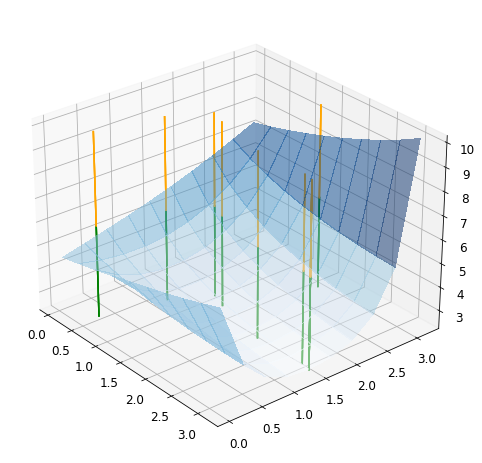

In [20]:
reference_plot = plot_3d_surface(fom_objective_functional, XX, YY, alpha=0.5)
reference_plot_mean_z_lim = 0.5*(reference_plot.get_zlim()[0] + reference_plot.get_zlim()[1])

for mu in reference_minimization_data['evaluation_points']:
    addplot_xy_point_as_bar(reference_plot, mu[0], mu[1], color='green',
                            z_range=(reference_plot.get_zlim()[0], reference_plot_mean_z_lim))

for mu in RB_minimization_data['evaluation_points']:
    addplot_xy_point_as_bar(reference_plot, mu[0], mu[1], color='orange',
                           z_range=(reference_plot_mean_z_lim, reference_plot.get_zlim()[1]))

In [21]:
def fom_gradient_of_functional(mu):
    return fom.output_d_mu(fom.parameters.parse(mu), return_array=True, use_adjoint=True)

opt_fom_minimization_data = {'num_evals': 0,
                            'evaluations' : [],
                            'evaluation_points': [],
                            'time': np.inf}
tic = perf_counter()
opt_fom_result = minimize(partial(record_results, fom_objective_functional, opt_fom_minimization_data),
                          initial_guess.to_numpy(),
                          method='L-BFGS-B',
                          jac=fom_gradient_of_functional,
                          bounds=(ranges, ranges),
                          options={'ftol': 1e-15})
opt_fom_minimization_data['time'] = perf_counter()-tic

# update the reference_mu because this is more accurate!
reference_mu = opt_fom_result.x

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

In [22]:
report(opt_fom_result, opt_fom_minimization_data)


 succeded!
  mu_min:    {diffusion: [1.4246656715132304, 3.141592653589793]}
  J(mu_min): 2.391707876129008
  num iterations:     8
  num function calls: 10
  time: 2.71084 seconds



In [23]:
def rom_gradient_of_functional(mu):
    return rom.output_d_mu(rom.parameters.parse(mu), return_array=True, use_adjoint=True)


opt_rom_minimization_data = {'num_evals': 0,
                             'evaluations' : [],
                             'evaluation_points': [],
                             'time': np.inf,
                             'offline_time': RB_greedy_data['time']}


tic = perf_counter()
opt_rom_result = minimize(partial(record_results, rom_objective_functional, opt_rom_minimization_data),
                  initial_guess.to_numpy(),
                  method='L-BFGS-B',
                  jac=rom_gradient_of_functional,
                  bounds=(ranges, ranges),
                  options={'ftol': 1e-15})
opt_rom_minimization_data['time'] = perf_counter()-tic
report(opt_rom_result, opt_rom_minimization_data, reference_mu)


 succeded!
  mu_min:    {diffusion: [1.4246650131874397, 3.141592653589793]}
  J(mu_min): 2.3917078349971868
  absolute error w.r.t. reference solution: 6.58e-07
  num iterations:     8
  num function calls: 10
  time: 0.03118 seconds
  offline time: 1.56933 seconds



In [24]:
pdeopt_reductor = CoerciveRBReductor(
    fom, product=fom.energy_product, coercivity_estimator=coercivity_estimator)

In [25]:
def record_results_and_enrich(function, data, opt_dict, mu):
    U = fom.solve(mu)
    try:
        pdeopt_reductor.extend_basis(U)
        data['enrichments'] += 1
    except:
        print('Extension failed')
    opt_rom = pdeopt_reductor.reduce()
    QoI = rom.output(mu)
    data['num_evals'] += 1
    # we need to make sure to copy the data, since the added mu will be changed inplace by minimize afterwards
    data['evaluation_points'].append([fom.parameters.parse(mu)['diffusion'][:][0],
                                      fom.parameters.parse(mu)['diffusion'][:][1]])
    data['evaluations'].append(QoI[0])
    opt_dict['opt_rom'] = rom
    return QoI

def compute_gradient_with_opt_rom(opt_dict, mu):
    opt_rom = opt_dict['opt_rom']
    return opt_rom.output_d_mu(opt_rom.parameters.parse(mu), return_array=True, use_adjoint=True)

In [26]:
opt_along_path_minimization_data = {'num_evals': 0,
                                       'evaluations' : [],
                                       'evaluation_points': [],
                                       'time': np.inf,
                                       'enrichments': 0}
opt_dict = {}
tic = perf_counter()
opt_along_path_result = minimize(partial(record_results_and_enrich, rom_objective_functional,
                                         opt_along_path_minimization_data, opt_dict),
                                  initial_guess.to_numpy(),
                                  method='L-BFGS-B',
                                  jac=partial(compute_gradient_with_opt_rom, opt_dict),
                                  bounds=(ranges, ranges),
                                  options={'ftol': 1e-15})
opt_along_path_minimization_data['time'] = perf_counter()-tic

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

Extension failed


In [27]:
report(opt_along_path_result, opt_along_path_minimization_data, reference_mu)


 succeded!
  mu_min:    {diffusion: [1.4246650131874397, 3.141592653589793]}
  J(mu_min): [2.39170783]
  absolute error w.r.t. reference solution: 6.58e-07
  num iterations:     8
  num function calls: 10
  time: 1.66610 seconds
  model enrichments: 9



In [28]:
pdeopt_reductor = CoerciveRBReductor(
    fom, product=fom.energy_product, coercivity_estimator=coercivity_estimator)
opt_rom = pdeopt_reductor.reduce()

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

In [29]:
def record_results_and_enrich_adaptively(function, data, opt_dict, mu):
    opt_rom = opt_dict['opt_rom']
    primal_estimate = opt_rom.estimate_error(opt_rom.parameters.parse(mu))
    if primal_estimate > 1e-2:
        print('Enriching the space because primal estimate is {} ...'.format(primal_estimate))
        U = fom.solve(mu)
        try:
            pdeopt_reductor.extend_basis(U)
            data['enrichments'] += 1
            opt_rom = pdeopt_reductor.reduce()
        except:
            print('... Extension failed')
    else:
        print('Do NOT enrich the space because primal estimate is {} ...'.format(primal_estimate))
    opt_rom = pdeopt_reductor.reduce()
    QoI = opt_rom.output(mu)
    data['num_evals'] += 1
    # we need to make sure to copy the data, since the added mu will be changed inplace by minimize afterwards
    data['evaluation_points'].append([fom.parameters.parse(mu)['diffusion'][:][0],
                                      fom.parameters.parse(mu)['diffusion'][:][1]])
    data['evaluations'].append(QoI[0])
    opt_dict['opt_rom'] = opt_rom
    return QoI

def compute_gradient_with_opt_rom(opt_dict, mu):
    opt_rom = opt_dict['opt_rom']
    return opt_rom.output_d_mu(opt_rom.parameters.parse(mu), return_array=True, use_adjoint=True)

In [30]:
opt_along_path_adaptively_minimization_data = {'num_evals': 0,
                                       'evaluations' : [],
                                       'evaluation_points': [],
                                       'time': np.inf,
                                       'enrichments': 0}
opt_dict = {'opt_rom': opt_rom}
tic = perf_counter()
opt_along_path_adaptively_result = minimize(partial(record_results_and_enrich_adaptively, rom_objective_functional,
                                                    opt_along_path_adaptively_minimization_data, opt_dict),
                                            initial_guess.to_numpy(),
                                            method='L-BFGS-B',
                                            jac=partial(compute_gradient_with_opt_rom, opt_dict),
                                            bounds=(ranges, ranges),
                                            options={'ftol': 1e-15})
opt_along_path_adaptively_minimization_data['time'] = perf_counter()-tic

Enriching the space because primal estimate is [2.98580267] ...


Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

Enriching the space because primal estimate is [0.08625045] ...


Do NOT enrich the space because primal estimate is [0.00063044] ...
Do NOT enrich the space because primal estimate is [0.00122583] ...
Do NOT enrich the space because primal estimate is [0.00234427] ...
Enriching the space because primal estimate is [0.0135848] ...


Enriching the space because primal estimate is [0.01046669] ...


Do NOT enrich the space because primal estimate is [0.00078205] ...
Do NOT enrich the space because primal estimate is [0.00078226] ...
Do NOT enrich the space because primal estimate is [0.00078227] ...


In [31]:
report(opt_along_path_adaptively_result, opt_along_path_adaptively_minimization_data, reference_mu)


 succeded!
  mu_min:    {diffusion: [1.4246660190392082, 3.141592653589793]}
  J(mu_min): [2.39170756]
  absolute error w.r.t. reference solution: 3.48e-07
  num iterations:     8
  num function calls: 10
  time: 0.58011 seconds
  model enrichments: 4



In [32]:
print('FOM with finite differences')
report(fom_result, reference_minimization_data, reference_mu)

print('\nROM with finite differences')
report(rom_result, RB_minimization_data, reference_mu)

print('\nFOM with gradient')
report(opt_fom_result, opt_fom_minimization_data, reference_mu)

print('\nROM with gradient')
report(opt_rom_result, opt_rom_minimization_data, reference_mu)

print('\nAlways enrich along the path')
report(opt_along_path_result, opt_along_path_minimization_data, reference_mu)

print('\nAdaptively enrich along the path')
report(opt_along_path_adaptively_result, opt_along_path_adaptively_minimization_data, reference_mu)

FOM with finite differences

 succeded!
  mu_min:    {diffusion: [1.4246544581196507, 3.141592653589793]}
  J(mu_min): 2.3917078762356825
  absolute error w.r.t. reference solution: 1.12e-05
  num iterations:     9
  num function calls: 36
  time: 3.16555 seconds


ROM with finite differences

 succeded!
  mu_min:    {diffusion: [1.424664977625628, 3.141592653589793]}
  J(mu_min): 2.3917078349971876
  absolute error w.r.t. reference solution: 6.94e-07
  num iterations:     8
  num function calls: 30
  time: 0.01425 seconds
  offline time: 1.56933 seconds


FOM with gradient

 succeded!
  mu_min:    {diffusion: [1.4246656715132304, 3.141592653589793]}
  J(mu_min): 2.391707876129008
  absolute error w.r.t. reference solution: 0.00e+00
  num iterations:     8
  num function calls: 10
  time: 2.71084 seconds


ROM with gradient

 succeded!
  mu_min:    {diffusion: [1.4246650131874397, 3.141592653589793]}
  J(mu_min): 2.3917078349971868
  absolute error w.r.t. reference solution: 6.58e-07
 